# Análisis de frecuencia de rango con uso de consensus clustering

Un aspecto que ha llamado la atención desde hace unos años en área de predicción en los sistemas de bike sharing ha sido el de poder encontrar similitudes entre las estaciones que forman parte del sistema. Al encontrar estas similitudes quizá nos traiga un atisbo que nos sea de ayuda en la planeación del sistema en la agregación, eliminación o un cambio que se realice en las estaciones.

En un experimento anterior hemos obtenido la diversidad de rango perteneciente a las estaciones de Ecobici en los periodos de la primera y tercera fase. Para este experimento utilizaremos un conjunto ligeramente diferente para obtener otro enfoque en la interpretabilidad que éstas nos puede arrojar sobre el comportamiento del sistema.

# Frecuencia de uso en el rango por estación.

Diversidad de rango puede verse como una medida en frecuencia de uso en el sistema, el siguiente enfoque que se presentará a continuación puede interpretarse como una medida de comportamiento en las estaciones mismas.

Primero que nada, se deben de obtener y tratar los datos para que obtenga la forma necesaria para realizar el análisis sobre ellos: Lo primero que se desea hacer es ordenar los conteos por estación $e_1$,$e_2$,...$e_n$ a lo largo de los días de manera que $e_1$ sea la estación con más conteos, seguido de $e_2$, hasta llegar a $e_n$, obteniendo una matriz de D x E donde D son los días transcurridos y E el conjunto de estaciones ordenados de mayor a menor:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from sklearn import preprocessing

In [2]:
def get_dr(phase):
    data = dict([(r[0], list(phase.columns[np.argsort(list(r)[1: ])[::-1]])) \
        for r in list(phase.to_records())])
    
    dr = pd.DataFrame.from_dict(data, orient='index', dtype=None)
    dr = dr.sort_index()

    return dr

In [3]:
def normalizeColumns(data):
    
    #returns scaled column values of a pandas dataset
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    dt_norm = pd.DataFrame(x_scaled)
    dt_norm.index = data.index
    
    return dt_norm

In [4]:
def plot_freqHeatmap(data):
    norm_data = normalizeColumns(data)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    ax[0].set_title('Station over rank frequency')
    ax[1].set_title('Normalized Station over rank frequency')
    
    yticks = data.index
    keptticks = yticks[::int(len(yticks)/10)]
    yticks = ['' for y in yticks]
    yticks[::int(len(yticks)/10)] = keptticks
    
    xticks = data.columns
    keptticks = xticks[::int(len(xticks)/10)]
    xticks = ['' for y in xticks]
    xticks[::int(len(xticks)/10)] = keptticks

    sns.heatmap(data, ax=ax[0], yticklabels=yticks, xticklabels=xticks)
    sns.heatmap(norm_data, ax=ax[1], yticklabels=yticks, xticklabels=xticks)
    
    #This sets the yticks "upright" with 0, as opposed to sideways with 90.
    plt.yticks(rotation=0) 

    plt.show()

In [5]:
def plot_freqHeatmap2(data):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
    ax.set_title('Normalized Station over rank frequency')
    
    yticks = data.index
    keptticks = yticks[::int(len(yticks)/10)]
    yticks = ['' for y in yticks]
    yticks[::int(len(yticks)/10)] = keptticks
    
    xticks = data.columns
    keptticks = xticks[::int(len(xticks)/10)]
    xticks = ['' for y in xticks]
    xticks[::int(len(xticks)/10)] = keptticks

    sns.heatmap(data, ax=ax, yticklabels=yticks, xticklabels=xticks)
    
    #This sets the yticks "upright" with 0, as opposed to sideways with 90.
    plt.yticks(rotation=0) 

    plt.show()

In [6]:
def frequencyRank(column):
    return column.value_counts()

In [7]:
def load_daytrips():
    path = 'ecobici.csv'
    trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)
    
    trips = trips.loc[trips['action'] != 'C  ']

    # Find the start date
    ind = pd.DatetimeIndex(trips.date_arrived)
    trips['date'] = ind.date.astype('datetime64')
    trips['hour'] = ind.hour

    # Count trips by date
    by_date = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )

    # add a flag indicating weekend
    by_date['weekend'] = (by_date.index.dayofweek >= 5)
    
    by_date_weekday = by_date[by_date['weekend'] == False]

    mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

    black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

    by_date_weekend = by_date[by_date['weekend'] == True]

    mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

    black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)
    
    # remove those values on the blacklist
    by_date = by_date.fillna(0)
    by_date = by_date.loc[~by_date.index.isin(black_list)]
    
    return by_date

In [8]:
station_phase_path = 'ecobiciFases.csv'

station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

Como se ha estado realizando en repetidas ocasiones, es de particular interés realizar este análisis sobre las diferentes fases por las que ha pasado Ecobici, es por eso que este análisis se realizará por fases como se ha estado realizando en los experimentos anteriores.

Se carga el archivo que mantiene el registro de actividad en las estaciones y se realiza una transformación para que quede a modo de conteos. Antes de realizar dicho análisis que de nueva cuenta se realizará la limpieza de los datos, deshaciéndose de los días con una actividad sospechosamente baja, después se eliminan las estaciones que no hayan formado parte en el periodo que comprende de la primera fase. Finalmente, recortamos los periodos posteriores a la apertura de la segunda y tercer fase. Más adelante se realizará un análisis sobre estos periodos por separado.

In [9]:
by_date = load_daytrips()
by_date.drop([col for col in list(by_date.columns.values) if col >= 91], axis=1, inplace=True)

In [10]:
phase_1 = by_date['2010-02-20':'2012-10-29']
dr = get_dr(phase_1)

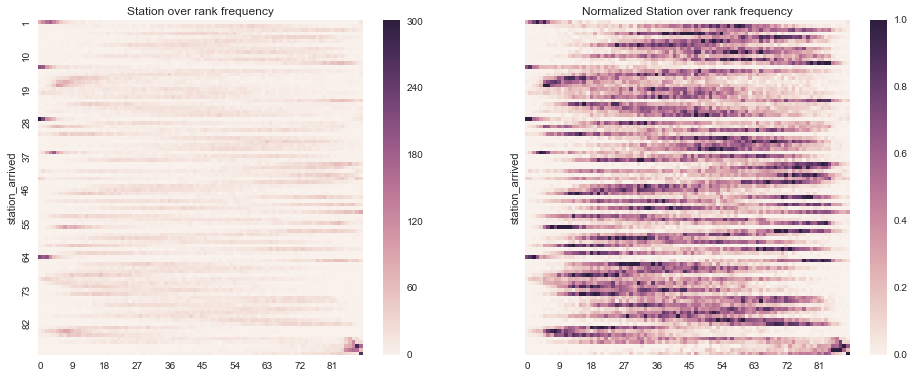

In [11]:
a1 = dr.apply(frequencyRank, axis=0).fillna(0)
a1.index = phase_1.columns
plot_freqHeatmap(a1)

In [12]:
norm_res = normalizeColumns(a1)
norm_res.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
station_arrived,,,,,,,,,,,,,,,,,,,,,
1,0.248344,0.536364,0.759804,1.000000,0.688172,0.938776,0.556818,0.278351,0.232558,0.178082,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049057
2,0.000000,0.000000,0.014706,0.005587,0.000000,0.040816,0.022727,0.030928,0.058140,0.054795,...,0.037736,0.017857,0.016393,0.03125,0.028986,0.000000,0.013699,0.030864,0.010949,0.026415
3,0.000000,0.000000,0.004902,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,0.013699,...,0.509434,0.357143,0.475410,0.40625,0.507246,0.206612,0.082192,0.117284,0.047445,0.018868
4,0.000000,0.000000,0.000000,0.005587,0.000000,0.010204,0.011364,0.000000,0.000000,0.027397,...,0.018868,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.003311,0.009091,0.004902,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.013699,...,0.471698,0.321429,0.229508,0.06250,0.130435,0.074380,0.054795,0.043210,0.025547,0.015094


###  Nota*

El heatmap que acaba de mostrarse tiene a su izquierda sus valores crudos, que sus valores oscilan entre 0 y 300, a la derecha se presentan estos mismos valores pero normalizados a lo largo de sus columnas, debido a este las celdas en la matriz son mejor apreciadas. En medida de experimento se realizará el proceso de clustering con el conjunto de datos normalizado. En el notebook siguiente se trabajará con la matriz de la izquierda.

# Técnicas de agrupación

Dejando al final un conjunto de 90 características para cada estación observada. Los siguiente que se propone en este experimento es el plantear un método para encontrar similitudes entre los conjuntos de datos de las estaciones mediante técnicas de clustering.

##  Clustering

Una de las ramas del aprendizaje automatizado es el aprendizaje no supervisado, éste consiste en buscar una relación entre las observaciones que se tienen estableciendo una medida similitud entre sus características representativas para dicho conjunto.
El problema implícito que se tiene cuando se está trabajando con este tipo de técnicas es que, a diferencia de las que tienen un objetivo o un resultado esperado, estas no disponen de una etiqueta para catalogar y/o evaluar la calidad del clustering realizado. Diferentes técnicas de clustering se han desarrollado para abordar este problema, tales como medir la compacidad de los clusters minimizando la distancia de los elementos agrupados un mismo cluster maximizando la distancia entre las agrupaciones.
Otro problema que se sucita al realizar esta técnica es el determinar el número de clusters ideal, evitando un número de clusters mayor que puedan aportar una estructura espuria para el modelo.

En este problema en particular tenemos que trabajar con una dificultad extra: Se dispone de un conjunto de datos un alto grado de dimensionalidad y un bajo número de observaciones, dicha descripción del problema pone en riesgo a la mayoría de métodos de clustering convencionales de ofrecer descripciones espurias sobre los datos.

## Consensus clustering
El método de clustering por el que se ha optado aquí es llamado Consensus Clustering (Monti et al.). Consensus clustering es un método de clusterización que ha ganado popularidad en el campo de genética debido a la robustez que ha mostrado en agrupaciones con alta dimensionalidad. Este método consiste en el submuestreo de tanto las observaciones como las características, sobre la hipótesis de que los elementos que comparten una similitud entre ellos no deben encontrar una radical diferencia en el plano multidimensional. Este método cuenta con una métrica de medición de calidad de clustering y decisión del número ideal de clusters a partir de una matriz generada durante la iteración de submuestreo llamada "Matriz de consenso", ésta genera visualizaciones que ilustran el nivel de consenso que existe cuando un elemento es agrupado con un conjunto en particular, donde el consenso es una división de la suma del número de veces que dos elementos fueron agrupados juntos entre el número de veces en que ambos elementos se encontraban presentes en el mismo submuestreo.
El resultado es un heatmap donde en el caso ideal los valores solo se representarían entre 0's (nunca agrupados juntos) y 1's (siempre agrupados juntos). Para más información consultar el artículo relacionado. 

### Especificaciones sobre el clustering:

El siguiente consensus clustering fue realizado con las siguientes especificaciones:
- Iteración de 2 a 13 clusters.
- 1000 iteraciones de submuestreo.
- 80% de las observaciones seleccionadas (sin reemplazo, esto para asegurar que no se generen agrupaciones sesgadas).
- 80% de las caracteristicas submuestreadas.
- Clustering jerárquico como método de clustering (Average linkage).
- Distancia Euclideana como medida de disimilaridad.

A diferencia de otras técnicas de clustering que existen, clustering jerárquico es afectado en gran parte por la diferencia en las medidas de sus características, es en parte por eso que se optó en la normalización de cada característica del conjunto de datos, así las medidas de similitud están representadas a una escala mejor distribuida.

Consensus clustering tiene ciertos criterios para determinar el número ideal de clusters a utilizar, tales como CDF (Cumulative Density Function) y el aumento de área relativo obtenido por las diferencias de las CDF de los clusters k al k+1. En este caso en particular a continuación se ofrecen las ilustraciónes:

# CDF

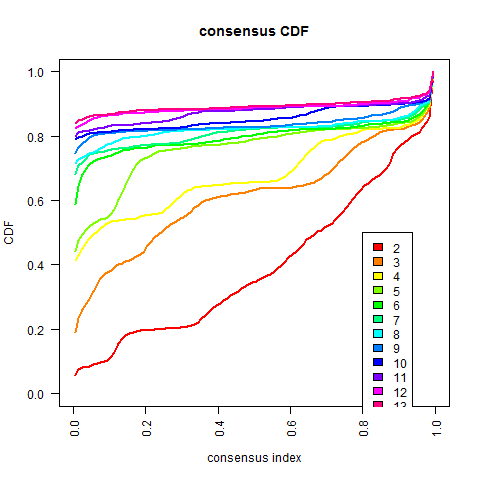

In [13]:
from IPython.display import Image
Image(filename='consensus014.png') 

# Delta area

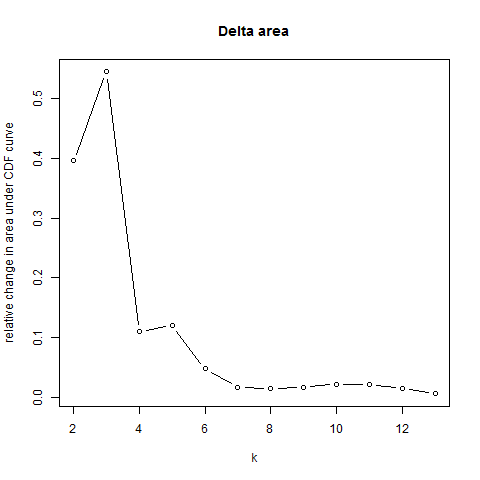

In [14]:
Image(filename='consensus015.png') 

# Tracking plot

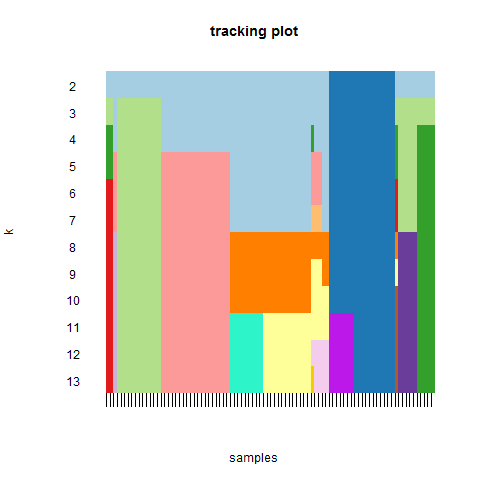

In [15]:
Image(filename='consensus016.png') 

Tracking plot es una grafica donde el eje horizontal representa los puntos en el muestreo y el eje vertical el número de clusters que se realizaron en las iteraciones. Sirve como un apoyo visual para llevar un historial de cuantas veces un punto en particular pasó de formar parte de un cluster a otro. Un punto con diferentes colores de longitudes similares muestra que esa característica en particular muestra una pertenencia muy débil a un cluster en particular. Una gráfica que contenga númerosas columnas con diferentes colores muestra un clustering inestable.

Bajo los criterios mencionados en el artículo, el número de clusters ideal para seleccionar es aquel donde el CDF alcance una estabilidad y el incremento relativo en el área sea cercano a 0. Los datos una agrupación que ofrecen un aumento gradual en su CDF a medida de que va aumentando el número de clusters hacen notar la debilidad de pertenencia que existe en los puntos con respecto a un grupo en particular.

Bajo los criterios recomendados se ha decidido hacer un análisis sobre K = 3 y K = 6, ya que K = 3 ofrece el aumento más alto en el área debajo de la CDF y K = 6 es el segundo aumento de mayor proporción más acercado a 0 y alcanza una estabilidad en su comportamiento en la CDF.

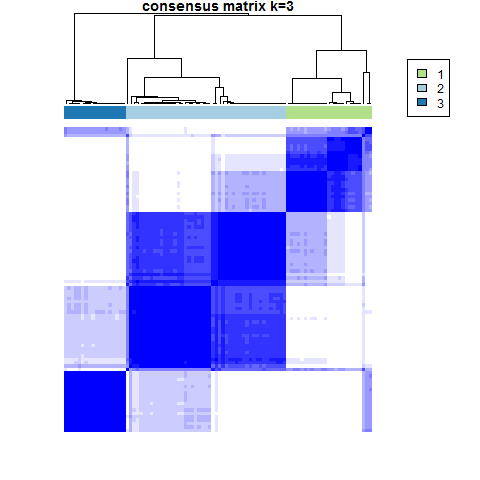

In [16]:
Image(filename='consensus003.png') 

# Geolocalización de las estaciones con los colores respectivos de su cluster

In [17]:
palette_3 = ['#B2DF8A','#1F78B4','#A6CEE3']
palette_6 = ['#FB9A99','#1F78B4','#E31A1C','#A6CEE3','#33A02C','#B2DF8A']

In [18]:
k_3 = pd.read_csv('clases_3_phase1.csv')
k_6 = pd.read_csv('clases_6_phase1.csv')

In [19]:
coors = pd.read_csv('estacion_coordenadas.csv')

In [20]:
#create empty map zoomed in on Mexico City
CDMX_COORDINATES = (19.4186, -99.1686) 

In [21]:
import folium 

map = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)

for i in coors.iterrows():
    if 'X'+str(int(i[1][0])) in k_3.transpose():
        folium.RegularPolygonMarker(
            [i[1][2], i[1][1]],
            popup=str(int(i[1][0])),
            fill_color=palette_3[k_3.transpose()['X'+str(int(i[1][0]))][0] - 1],
            number_of_sides=6,
            radius=10
            ).add_to(map)
    
map

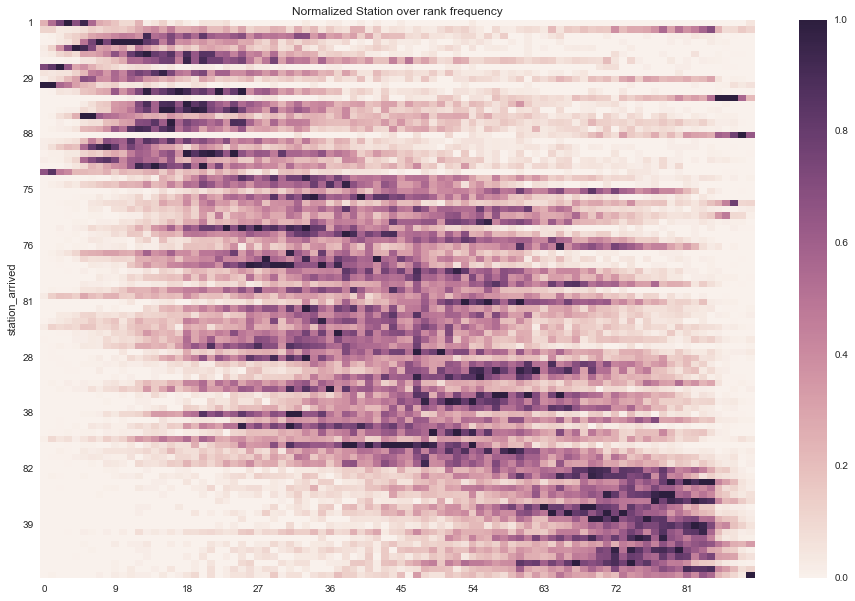

In [22]:
norm_res['cluster'] = k_3.values
temp_res = norm_res.sort_values(['cluster'])
plot_freqHeatmap2(temp_res[temp_res.columns.difference(['cluster'])])

Observando el heatmap anterior es evidente deducir que lo que realizó el clustering es agrupar las estaciones cuya actividad se concentra en los primeros, medianos y últimos rangos.

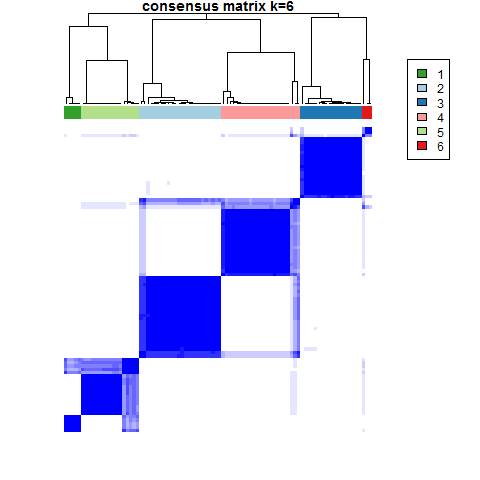

In [23]:
Image(filename='consensus006.png') 

In [24]:
map2 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)

for i in coors.iterrows():
    if 'X'+str(int(i[1][0])) in k_6.transpose():
        folium.RegularPolygonMarker(
            [i[1][2], i[1][1]],
            popup=str(int(i[1][0])),
            fill_color=palette_6[k_6.transpose()['X'+str(int(i[1][0]))][0] - 1],
            number_of_sides=6,
            radius=10
            ).add_to(map2)
    
map2

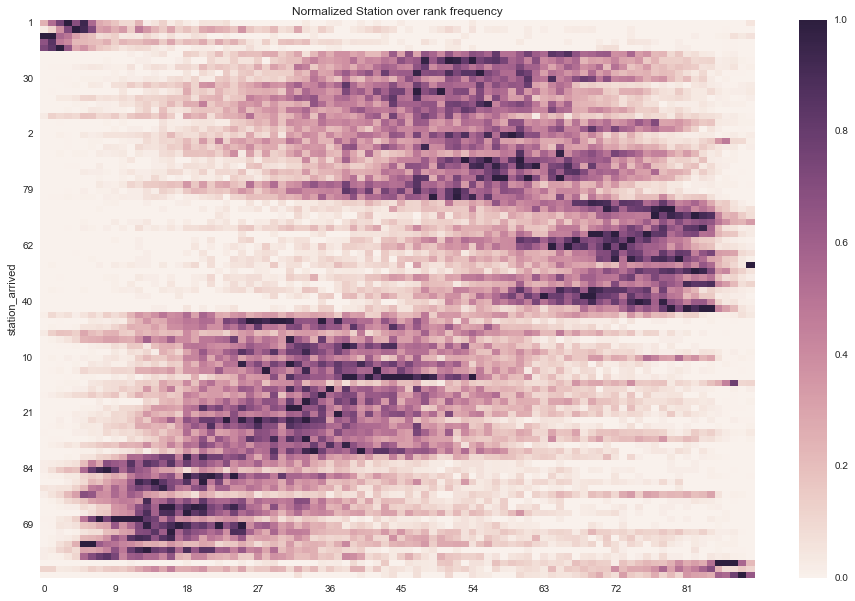

In [25]:
norm_res['cluster'] = k_6.values
temp_res = norm_res.sort_values(['cluster'])
plot_freqHeatmap2(temp_res[temp_res.columns.difference(['cluster'])])

Este clustering realizó agrupaciones más ponderadas en las diferentes concentraciones de las frecuencias. Puede verse que cada uno de los 6 clusters ahora representa una concentración importante en las frecuencias de las estaciones y los rangos, por otro lado las características asociadas con las distancias entre estaciones y puntos de la ciudad no representan un patrón visible.

### Consensus clustering sobre la fase 3

Una vez realizado el análisis en el periodo de la primera estación, realizamos los mismo pasos para la tercer fase. es importante hacer destacar que el número de rangos aumenta debido a la apertura de nuevas estaciones en el sistema, pasando de 90 estaciones a 266 aunque la idea fundamental debe prevalecer: las características para cada estación a lo largo de los rangos son una descripción clara de la importancia que estas tienen en el sistema a lo largo de los días.

In [26]:
phase_3 = load_daytrips()
phase_3.drop([col for col in list(phase_3.columns.values) if col not in station_phase[station_phase['phase'] <= 3]['station'].values], 
             axis=1, inplace=True)
phase_3 = phase_3['2012-11-29':]

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


In [27]:
dr3 = get_dr(phase_3)

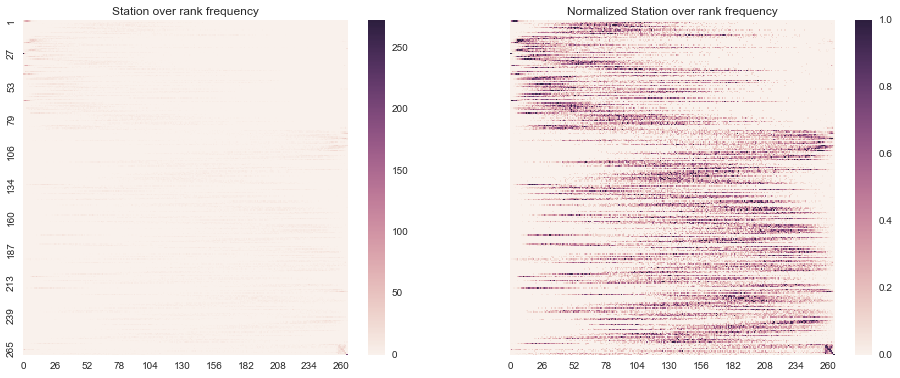

In [28]:
a3 = dr3.apply(frequencyRank, axis=0).fillna(0)
plot_freqHeatmap(a3)

In [29]:
res3 = a3
norm_res3 = normalizeColumns(res3)

In [30]:
palette3_3 = ['#A6CEE3','#1F78B4','#B2DF8A']
palette3_6 = ['#1F78B4','#FB9A99','#A6CEE3','#E31A1C','#33A02C','#B2DF8A']

In [31]:
k3_3 = pd.read_csv('clases_3_phase3.csv')
k3_6 = pd.read_csv('clases_6_phase3.csv')

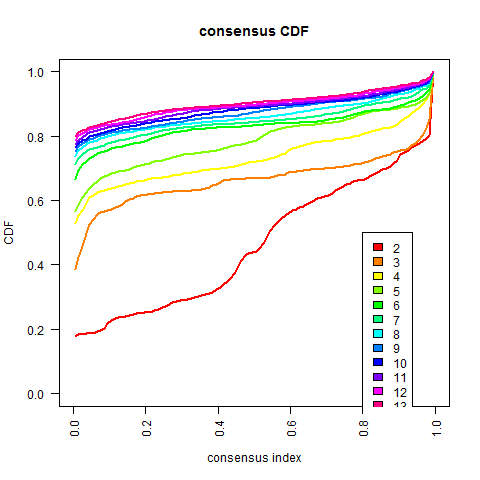

In [32]:
Image(filename='consensus014.png') 

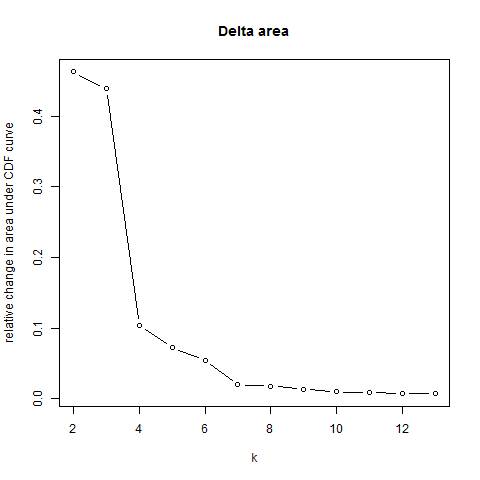

In [33]:
Image(filename='phase3\consensus015.png') 

Una vez más para realizar el análisis se tomaron K = 3 y K = 6 por motivos similares a los anteriormente planteados.

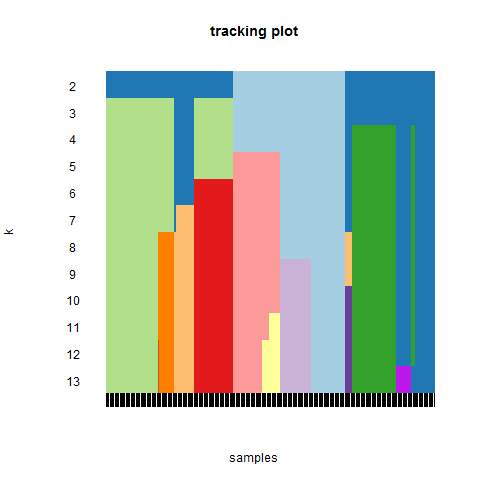

In [34]:
Image(filename='phase3\consensus016.png') 

Cabe señalar que el tracking plot en este caso muestra algunos puntos que cambiaron gradualmente de cluster, exponiendo su inestabilidad y falta estructura para las medidas del cluster utilizadas.

In [35]:
map4 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)

for i in coors.iterrows():
    if 'X'+str(int(i[1][0])) in k3_3.transpose():
        folium.RegularPolygonMarker(
            [i[1][2], i[1][1]],
            popup=str(int(i[1][0])),
            fill_color=palette3_3[k3_3.transpose()['X'+str(int(i[1][0]))][0] - 1],
            number_of_sides=6,
            radius=10
            ).add_to(map4)
    
map4

Estaciones con una alta actividad se sitúan en el centro del sistema, por lo que se puede apreciar.

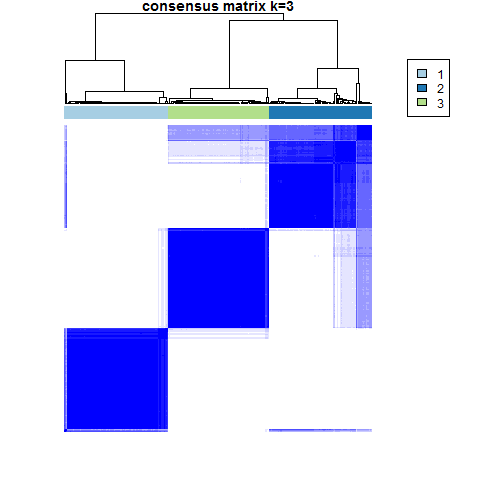

In [36]:
Image(filename='phase3\consensus003.png') 

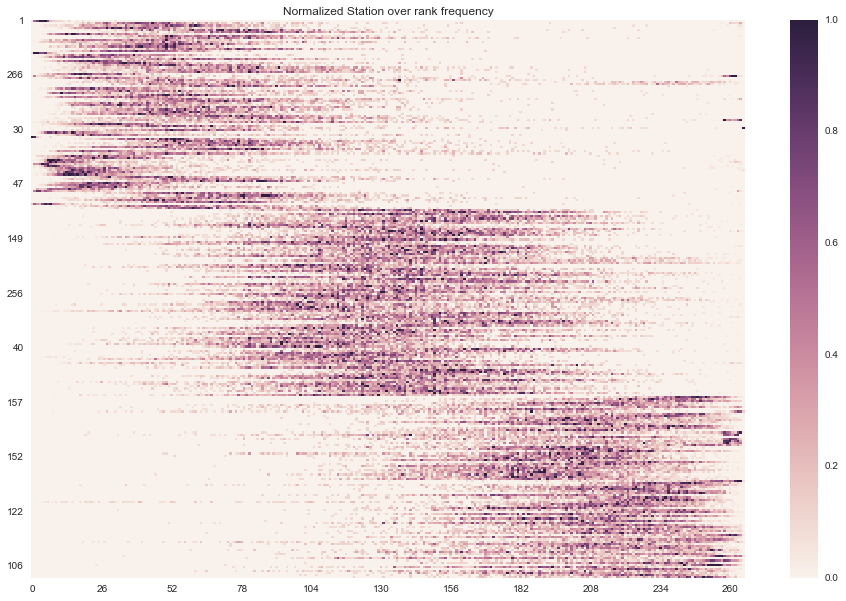

In [37]:
norm_res3['cluster'] = k3_3.values
temp_res3 = norm_res3.sort_values(['cluster'])
plot_freqHeatmap2(temp_res3[temp_res3.columns.difference(['cluster'])])

In [38]:
map3 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)

for i in coors.iterrows():
    if 'X'+str(int(i[1][0])) in k3_6.transpose():
        folium.RegularPolygonMarker(
            [i[1][2], i[1][1]],
            popup=str(int(i[1][0])),
            fill_color=palette3_6[k3_6.transpose()['X'+str(int(i[1][0]))][0] - 1],
            number_of_sides=6,
            radius=10
            ).add_to(map3)
    
map3

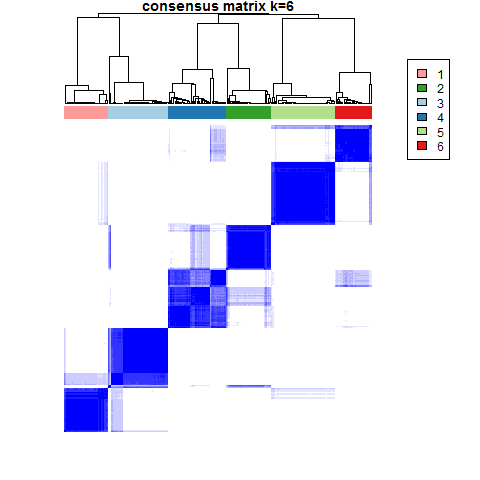

In [39]:
Image(filename='phase3\consensus006.png') 

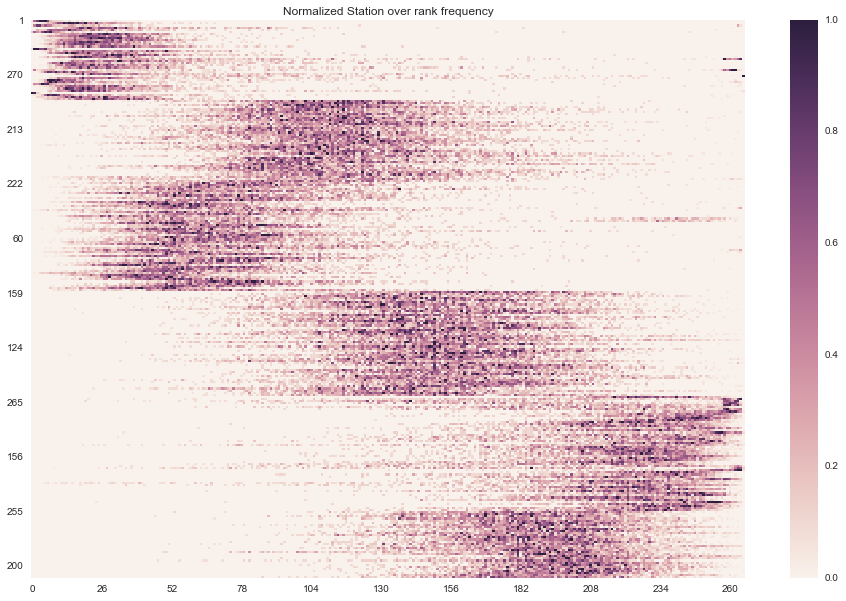

In [40]:
norm_res3['cluster'] = k3_6.values
temp_res3 = norm_res3.sort_values(['cluster'])
plot_freqHeatmap2(temp_res3[temp_res3.columns.difference(['cluster'])])

De nueva cuenta, a mayor número de clusters introducidos mayores grupos que sobresalten regiones con mayor freguencia emergerán.

El siguiente notebook consistirá en realizar este mismo análisis, la única diferencia será que los datos que se utilicen no estarán normalizados.

In [41]:
from IPython.display import HTML

#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')